In [7]:
import pandas as pd
import numpy as np

Loading the Data

In [8]:
df = pd.read_csv("fnma-dataset-complete.tar.gz", sep="|")
df

,loan_id,upb,note_rate,borrower_fico,coborrower_fico,combined_fico,state,dti,ltv,maturity_date,loan_term,property_type
0,128090409,171000.0,2.990,808.0,814.0,811,NY,47.0,48,102051.0,360,SF
1,128090410,450000.0,2.875,803.0,NaN,803,NY,48.0,46,92051.0,360,SF
2,128090411,604000.0,2.990,762.0,792.0,777,NY,45.0,55,102051.0,360,SF
3,128090412,300000.0,2.250,766.0,NaN,766,NY,23.0,35,42051.0,360,SF
4,128090420,205000.0,3.250,794.0,774.0,784,KY,21.0,69,102051.0,360,PU
...,...,...,...,...,...,...,...,...,...,...,...,...
1542129,134439941,200000.0,6.000,654.0,NaN,654,TN,42.0,65,92052.0,360,SF
1542130,134439943,576000.0,5.375,765.0,781.0,773,NY,28.0,80,92052.0,360,SF
1542131,134439944,440000.0,6.325,742.0,689.0,715,MN,49.0,80,92052.0,360,SF
1542132,134439945,152000.0,5.375,717.0,NaN,717,CA,39.0,70,92052.0,360,CO


In [9]:
pool_info_df = pd.DataFrame({
    "min_size": [5e6, 5e6, 5e6, 5e6, 5e6, 5e6, 5e6, 15e6, 15e6, 15e6],
    "max_size": [20e6, 20e6, 20e6, 20e6, 20e6, 30e6, 30e6, 40e6, 40e6, 40e6],
    "note_rate_min": [5, 4, 3, 3, 3, 3, 2, 1.5, 1.5, 1.5],
    "note_rate_max": [7, 6, 7, 7, 7, 7, 5, 7, 9, 6.5],
    "FICO_min": [640, 600, 600, 670, 675, 690, 720, 550, 730, 400],
    "FICO_max": [745, 770, 700, 750, 780, 790, 850, 740, 770, 850],
    "state_pct": [0.05, 0.05, 0.1, 0.05, 0.05, 0.15, 0.05, 0.05, 0.05, 0.25],
    "dti_min": [35, 40, 45, 47, 30, 15, 10, 20, 35, 20],
    "dti_max": [50, 45, 55, 52, 55, 35, 45, 45, 45, 60],
    "ltv_min": [75, 70, 60, 35, 60, 70, 70, 0, 90, 70],
    "ltv_max": [85, 90, 95, 80, 85, 85, 80, 85, 95, 99]
},
index=pd.RangeIndex(1, 11, name="class")
)
pool_info_df

,min_size,max_size,note_rate_min,note_rate_max,FICO_min,FICO_max,state_pct,dti_min,dti_max,ltv_min,ltv_max
class,,,,,,,,,,,
1,5000000.0,20000000.0,5.0,7.0,640,745,0.05,35,50,75,85
2,5000000.0,20000000.0,4.0,6.0,600,770,0.05,40,45,70,90
3,5000000.0,20000000.0,3.0,7.0,600,700,0.10,45,55,60,95
4,5000000.0,20000000.0,3.0,7.0,670,750,0.05,47,52,35,80
5,5000000.0,20000000.0,3.0,7.0,675,780,0.05,30,55,60,85
6,5000000.0,30000000.0,3.0,7.0,690,790,0.15,15,35,70,85
7,5000000.0,30000000.0,2.0,5.0,720,850,0.05,10,45,70,80
8,15000000.0,40000000.0,1.5,7.0,550,740,0.05,20,45,0,85
9,15000000.0,40000000.0,1.5,9.0,730,770,0.05,35,45,90,95


In [10]:
def satisfies_crit(entry, crit):
    # Figures out if an entry could potentially
    # be part of a pool class.
    # NOTE: This does not check UPB values
    # You are also responsible for checking the state pctage is within limits
    return \
    (crit["note_rate_min"] <= entry["note_rate"] <= crit["note_rate_max"]) and \
    (crit["FICO_min"] <= entry["combined_fico"] <= crit["FICO_max"]) and \
    (crit["dti_min"] <= entry["dti"] <= crit["dti_max"]) and \
    (crit["ltv_min"] <= entry["ltv"] <= crit["ltv_max"])

def find_valid_crits(entry, crit_df):
    """
    Returns OHE of which class pools an entry can be put in
    """
    valid_crits = np.zeros(len(crit_df))
    for i, (_, row) in enumerate(crit_df.iterrows()):
        if satisfies_crit(entry, row):
            valid_crits[i] = 1
    return valid_crits

Best Case Score Analysis

In [11]:
0.55 * (df["upb"].sum() / 1e6)

257484.65600000002

Looking at the criteria for classifying loans to put into pools, the state %, seems like a pretty large restriction.

Let's see how this % translates into requirements for the number of states in a pool

Class 1: 5% state percentage (at least 20 states in a pool)

Class 2: same

Class 3: >= 10 states in a pool

Class 4: >= 20 states

Class 5: >= 20 states

class 6: >= 5 states

Class 7: >= 20 states

Class 8: >= 20 states

Class 9: >= 20 states

Class 10: >= 4 states

Having at least 4 states for the worst classs of pools (10) and at least 20 states, to get a good pool class, seems like
a pretty big restriction, let's see how much inpact it makes.

In [12]:
# First let's see how many states are there
unique_states = df["state"].unique()
len(unique_states)

53

In [13]:
# Why?
# Looks like we are counting other things like DC and Puerto Rico
unique_states

array(['NY', 'KY', 'FL', 'VA', 'NV', 'TX', 'TN', 'UT', 'CA', 'CO', 'GA',
       'IL', 'WA', 'PA', 'MI', 'OR', 'NH', 'MN', 'MD', 'MA', 'NJ', 'AZ',
       'AL', 'AK', 'ID', 'ME', 'CT', 'KS', 'NC', 'OH', 'IN', 'LA', 'VT',
       'SD', 'IA', 'NM', 'MT', 'OK', 'SC', 'HI', 'AR', 'WV', 'WI', 'MO',
       'NE', 'MS', 'RI', 'DE', 'ND', 'WY', 'VI', 'DC', 'PR'], dtype=object)

<AxesSubplot: >

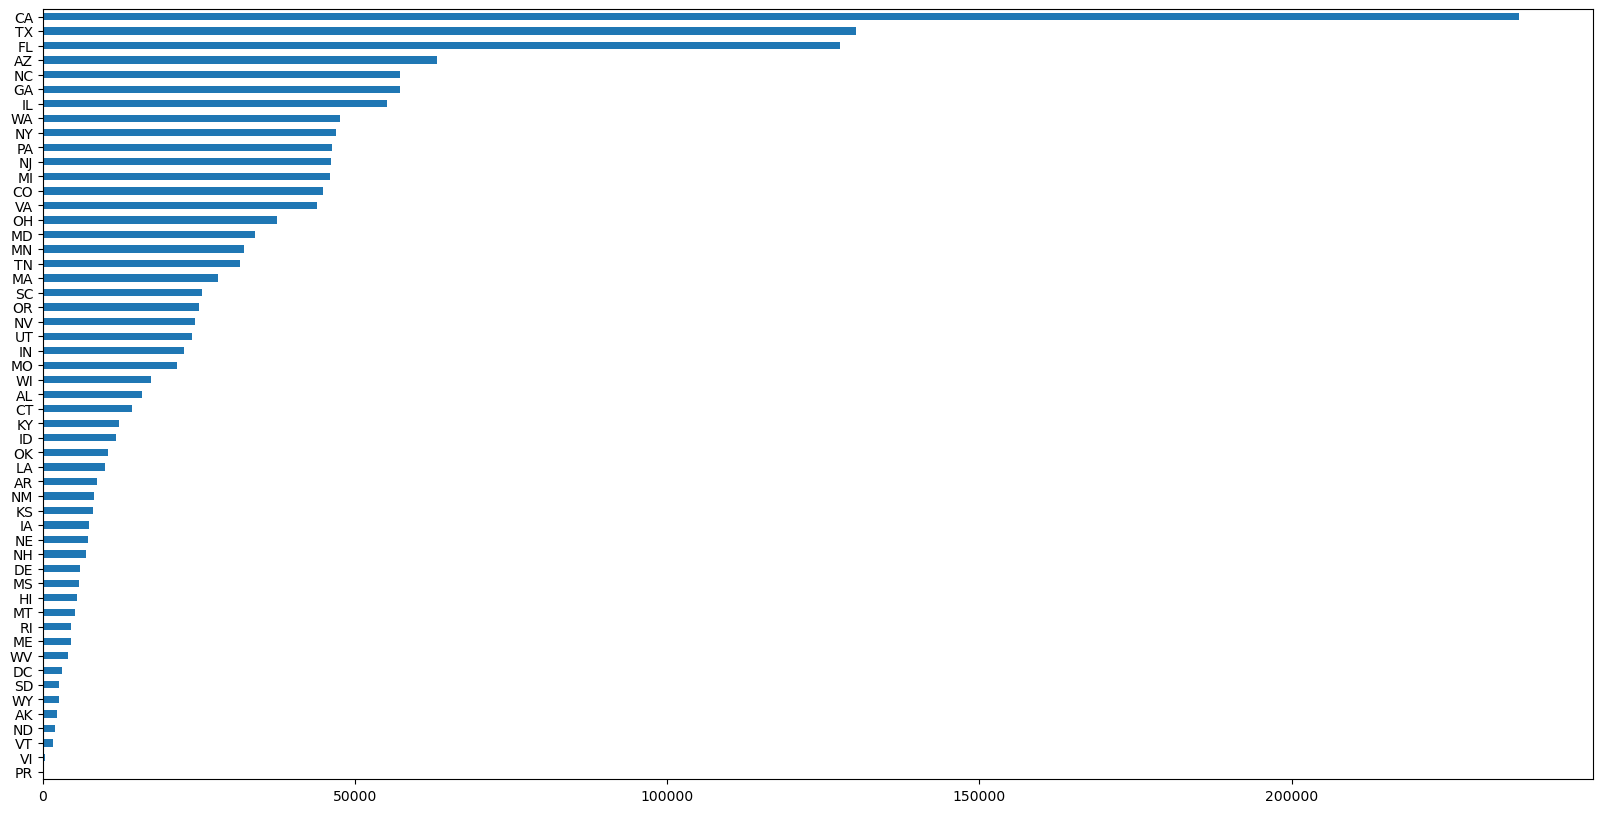

In [14]:
# Plotting the state distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
df["state"].value_counts(ascending=True).plot(kind="barh")

In [34]:
# How many states make up 50% of the data
#state_cnts[state_cnts.cumsum() < state_cnts.sum() / 2]

AK    37
AL    37
AR    37
AZ    37
CA    37
CO    37
CT    37
DC    37
DE    37
FL    37
GA    37
HI    37
IA    37
ID    37
IL    37
IN    37
KS    37
KY    37
LA    37
MA    37
MD    37
ME    37
MI    37
MN    37
MO    37
dtype: int64

Wow, only 7 states make up half of the loans

In [16]:
# Divide into groups and enforce restriciton that maturity_date, and loan_term must be same
# TODO: property_type restrictions?
df_gb = df.groupby(["loan_term","maturity_date"])
df_gb

In [17]:
df_gb_st = df.groupby(["loan_term", "maturity_date", "state"])
group_st_cnts = df_gb_st.count()
group_st_cnts

loan_id   upb  note_rate  borrower_fico  \
loan_term maturity_date state                                            
85        12029.0       PA           1     1          1              1   
          22029.0       WI           1     1          1              1   
          92029.0       GA           1     1          1              1   
96        12030.0       AL           7     7          7              7   
                        AR           1     1          1              1   
...                                ...   ...        ...            ...   
360       122051.0      VT         119   119        119            119   
                        WA        4618  4618       4618           4616   
                        WI        1385  1385       1385           1385   
                        WV         328   328        328            328   
                        WY         250   250        250            250   

                               coborrower_fico  combined_fico   dti   ltv  \
loan_term maturity_date state                                               
85        12029.0       PA                   1              1     1     1   
          22029.0       WI                   0              1     1     1   
          92029.0       GA                   1              1     1     1   
96        12030.0       AL                   4              7     7     7   
                        AR                   1              1     1     1   
...                                        ...            ...   ...   ...   
360       122051.0      VT                  54            119   119   119   
                        WA                2197           4618  4618  4618   
                        WI                 659           1385  1385  1385   
                        WV                 115            328   328   328   
                        WY                 114            250   250   250   

                               property_type  
loan_term maturity_date state                 
85        12029.0       PA                 1  
          22029.0       WI                 1  
          92029.0       GA                 1  
96        12030.0       AL                 7  
                        AR                 1  
...                                      ...  
360       122051.0      VT               119  
                        WA              4618  
                        WI              1385  
                        WV               328  
                        WY               250  

[10124 rows x 9 columns]

In [18]:
# Counting the number of unique states per loan_term/maturity_date group

group_st_cnts = group_st_cnts.reset_index(level="state") # Turn state into a column
group_st_cnts = group_st_cnts.groupby(level=["loan_term", "maturity_date"]).count()
group_st_cnts

state  loan_id  upb  note_rate  borrower_fico  \
loan_term maturity_date                                                  
85        12029.0            1        1    1          1              1   
          22029.0            1        1    1          1              1   
          92029.0            1        1    1          1              1   
96        12030.0           47       47   47         47             47   
          22030.0           43       43   43         43             43   
...                        ...      ...  ...        ...            ...   
360       92052.0           53       53   53         53             53   
          102051.0          52       52   52         52             52   
          102052.0          53       53   53         53             53   
          112051.0          52       52   52         52             52   
          122051.0          52       52   52         52             52   

                         coborrower_fico  combined_fico  dti  ltv  \
loan_term maturity_date                                             
85        12029.0                      1              1    1    1   
          22029.0                      1              1    1    1   
          92029.0                      1              1    1    1   
96        12030.0                     47             47   47   47   
          22030.0                     43             43   43   43   
...                                  ...            ...  ...  ...   
360       92052.0                     53             53   53   53   
          102051.0                    52             52   52   52   
          102052.0                    53             53   53   53   
          112051.0                    52             52   52   52   
          122051.0                    52             52   52   52   

                         property_type  
loan_term maturity_date                 
85        12029.0                    1  
          22029.0                    1  
          92029.0                    1  
96        12030.0                   47  
          22030.0                   43  
...                                ...  
360       92052.0                   53  
          102051.0                  52  
          102052.0                  53  
          112051.0                  52  
          122051.0                  52  

[941 rows x 10 columns]

In [35]:
# For verification purposes
df_360_122051 = df[(df["loan_term"] == 360) & (df["maturity_date"] == 122051.0)]
len(df_360_122051["state"].unique())

0

<AxesSubplot: >

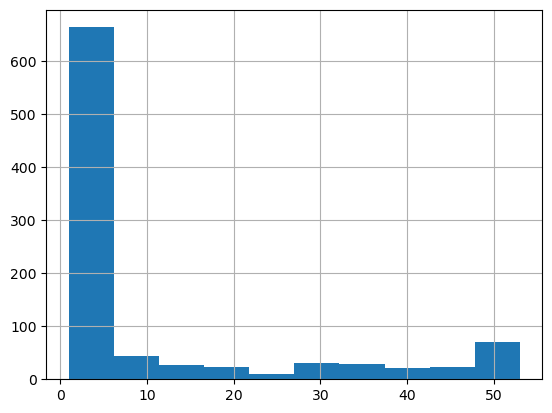

In [20]:
#group_st_cnts.sort_values(by="state", ascending=False).plot(y="state", kind="bar")
# Plotting the Number of unique states per group (loan_term, maturity_date pair
# This shows that most groups have very few states
# We will analyze how many in the next sections
group_st_cnts.sort_values(by="state", ascending=False)["state"].hist()

Wow, it looks like we have a heavily right-skewed distribution here, so we should be able to construct a decent #
of higher-valued groups.

Phew!

(See analysis below for how many of the )

So, to recap, we have 941 groups that can be used to form pools.

In [21]:
group_st_cnts[group_st_cnts["state"] >= 20]

state  loan_id  upb  note_rate  borrower_fico  \
loan_term maturity_date                                                  
96        12030.0           47       47   47         47             47   
          22030.0           43       43   43         43             43   
          32030.0           45       45   45         45             45   
          42030.0           43       43   43         43             43   
          52030.0           36       36   36         36             36   
...                        ...      ...  ...        ...            ...   
360       92052.0           53       53   53         53             53   
          102051.0          52       52   52         52             52   
          102052.0          53       53   53         53             53   
          112051.0          52       52   52         52             52   
          122051.0          52       52   52         52             52   

                         coborrower_fico  combined_fico  dti  ltv  \
loan_term maturity_date                                             
96        12030.0                     47             47   47   47   
          22030.0                     43             43   43   43   
          32030.0                     45             45   45   45   
          42030.0                     43             43   43   43   
          52030.0                     36             36   36   36   
...                                  ...            ...  ...  ...   
360       92052.0                     53             53   53   53   
          102051.0                    52             52   52   52   
          102052.0                    53             53   53   53   
          112051.0                    52             52   52   52   
          122051.0                    52             52   52   52   

                         property_type  
loan_term maturity_date                 
96        12030.0                   47  
          22030.0                   43  
          32030.0                   45  
          42030.0                   43  
          52030.0                   36  
...                                ...  
360       92052.0                   53  
          102051.0                  52  
          102052.0                  53  
          112051.0                  52  
          122051.0                  52  

[195 rows x 10 columns]

In [22]:
valid_groups = group_st_cnts[group_st_cnts["state"] >= 4]
valid_groups

state  loan_id  upb  note_rate  borrower_fico  \
loan_term maturity_date                                                  
96        12030.0           47       47   47         47             47   
          22030.0           43       43   43         43             43   
          32030.0           45       45   45         45             45   
          42030.0           43       43   43         43             43   
          52030.0           36       36   36         36             36   
...                        ...      ...  ...        ...            ...   
360       92052.0           53       53   53         53             53   
          102051.0          52       52   52         52             52   
          102052.0          53       53   53         53             53   
          112051.0          52       52   52         52             52   
          122051.0          52       52   52         52             52   

                         coborrower_fico  combined_fico  dti  ltv  \
loan_term maturity_date                                             
96        12030.0                     47             47   47   47   
          22030.0                     43             43   43   43   
          32030.0                     45             45   45   45   
          42030.0                     43             43   43   43   
          52030.0                     36             36   36   36   
...                                  ...            ...  ...  ...   
360       92052.0                     53             53   53   53   
          102051.0                    52             52   52   52   
          102052.0                    53             53   53   53   
          112051.0                    52             52   52   52   
          122051.0                    52             52   52   52   

                         property_type  
loan_term maturity_date                 
96        12030.0                   47  
          22030.0                   43  
          32030.0                   45  
          42030.0                   43  
          52030.0                   36  
...                                ...  
360       92052.0                   53  
          102051.0                  52  
          102052.0                  53  
          112051.0                  52  
          122051.0                  52  

[373 rows x 10 columns]

195 groups have at least 20 states (eligible for higher value classes e.g. class 1) and
373 groups are valid groups (you need at least 4 states to satisfy the state requirement)

This seems like a steep drop from the 900ish groups, but we should remember that not all groups are equally sized.

We'll need to actually pull the groups from our original DataFrame to see how many records we really need to process

In [23]:
df_idx = df.set_index(["loan_term", "maturity_date"])

In [24]:
valid_df = df_idx.loc[valid_groups.index]
valid_df

loan_id       upb  note_rate  borrower_fico  \
loan_term maturity_date                                                  
96        12030.0        129597124  292000.0      2.125          774.0   
          12030.0        129597679  100000.0      2.750          736.0   
          12030.0        129600187   81000.0      2.875          704.0   
          12030.0        129600946  185000.0      2.250          761.0   
          12030.0        129608426  183000.0      2.500          745.0   
...                            ...       ...        ...            ...   
360       122051.0       133835504  149000.0      3.375          787.0   
          122051.0       133868470  400000.0      3.000          790.0   
          122051.0       133880031  506000.0      2.990          693.0   
          122051.0       133888868  225000.0      3.625          752.0   
          122051.0       133894725  226000.0      3.875          685.0   

                         coborrower_fico  combined_fico state   dti  ltv  \
loan_term maturity_date                                                    
96        12030.0                    NaN            774    VA  29.0   50   
          12030.0                    NaN            736    MT  37.0   57   
          12030.0                    NaN            704    MI  23.0   24   
          12030.0                  767.0            764    AL  24.0   42   
          12030.0                    NaN            745    CT  43.0   67   
...                                  ...            ...   ...   ...  ...   
360       122051.0                   NaN            787    GA  39.0   39   
          122051.0                   NaN            790    CA  50.0   62   
          122051.0                 736.0            714    NY  47.0   51   
          122051.0                   NaN            752    NY  31.0   90   
          122051.0                   NaN            685    CT  40.0   73   

                        property_type  
loan_term maturity_date                
96        12030.0                  SF  
          12030.0                  SF  
          12030.0                  SF  
          12030.0                  SF  
          12030.0                  SF  
...                               ...  
360       122051.0                 PU  
          122051.0                 SF  
          122051.0                 SF  
          122051.0                 CO  
          122051.0                 SF  

[1541183 rows x 10 columns]

In [25]:
df

,loan_id,upb,note_rate,borrower_fico,coborrower_fico,combined_fico,state,dti,ltv,maturity_date,loan_term,property_type
0,128090409,171000.0,2.990,808.0,814.0,811,NY,47.0,48,102051.0,360,SF
1,128090410,450000.0,2.875,803.0,NaN,803,NY,48.0,46,92051.0,360,SF
2,128090411,604000.0,2.990,762.0,792.0,777,NY,45.0,55,102051.0,360,SF
3,128090412,300000.0,2.250,766.0,NaN,766,NY,23.0,35,42051.0,360,SF
4,128090420,205000.0,3.250,794.0,774.0,784,KY,21.0,69,102051.0,360,PU
...,...,...,...,...,...,...,...,...,...,...,...,...
1542129,134439941,200000.0,6.000,654.0,NaN,654,TN,42.0,65,92052.0,360,SF
1542130,134439943,576000.0,5.375,765.0,781.0,773,NY,28.0,80,92052.0,360,SF
1542131,134439944,440000.0,6.325,742.0,689.0,715,MN,49.0,80,92052.0,360,SF
1542132,134439945,152000.0,5.375,717.0,NaN,717,CA,39.0,70,92052.0,360,CO


Looks like we only lost ~951 loans. 

In [31]:
# Making the pools

# Mapping of Pool class (int) to list of pools (which are DataFrames)
result_dict = {}

valid_gb = valid_df.groupby(level=["loan_term", "maturity_date"])
for _, group in valid_gb:
    # Sort by UPB 
    # (in descending, since we want each pool to have fewer elems, so we can end up with more pools) then
    # Group by States (to satisfy state criteria)
    # (Each group should still be sorted after the groupby)
    group = group.reset_index()
    group = group.set_index("loan_id")
    group = group.sort_values(by="upb", ascending=True)
    # Mark which pool classes a loan is eligible for
    # in OHE columns
    #print(group)
    group[list(range(1,11))] = group.apply(find_valid_crits, result_type="expand", axis=1, crit_df=pool_info_df)

    #group_states = group.groupby("state")

    #num_states = len(group_states.groups)

    # TODO: Re-enable this optimization
    # # Check if we cannot already form some classes
    # # b/c of not having enough states
    # max_state_pct = 1/num_states
    # poss_pool_cls = pool_info_df[pool_info_df["state_pct"] > max_state_pct]

    # 1-pool per class, when the pool fills up, we push it into the result_dict
    # and empty until we done
    for curr_cls in range(1, 11):
        cls_info = pool_info_df.loc[curr_cls]
        # We want to make as big pools as possible
        min_val = cls_info["min_size"]
        max_val = cls_info["max_size"]

        # TODO: Use multiple pools at once?
        curr_pool = []
        curr_sum = 0


        # A Series(basically a dict) that we will use to track number of states in the pool.
        # State name -> count
        state_cnts = pd.Series()

        # Get all eligible values
        elig_rows = group[group[curr_cls] == 1]
        if len(elig_rows) == 0:
            continue

        # Groupby state
        elig_gb = elig_rows.groupby("state")

        # Round-robin below
        done = False
        group_pos = np.zeros(len(elig_gb.groups),dtype="int64")
        min_reached = False #set to false every new pool we make. True for a loop through states => done with class
        indexes = []
        while not done:
            prev_sum = curr_sum
            for i, (_, curr_group) in enumerate(elig_gb):
                if group_pos[i] >= len(curr_group):
                    continue
                row = curr_group.iloc[group_pos[i]]
                # Add to the current pool
                # We need to remember to drop the extra columns we added
                if curr_sum + row["upb"] > max_val:
                    continue
                    
                curr_pool.append(row.drop(list(range(1,11))))
                indexes.append(row.name)
                curr_sum += row["upb"]

                group_pos[i] += 1
                state = row["state"]
                state_cnt = state_cnts.get(state, 0) # The Count if it exists, otherwise 0
                state_cnts[state] = state_cnt + 1


                if (state_cnts[state])/(len(curr_pool)) < cls_info["state_pct"]:
                    # Path that triggers emptying the curr_pool into result_dict
                    # If we satisfy state count, then check if sum is in range
                    # if so than we empty into result_dict
                    if curr_sum >= min_val:
                        #print("hi")
                        # add to final dict
                        existing_pool = result_dict.get(curr_cls, [])
                        existing_pool.append(curr_pool)
                        result_dict[curr_cls] = existing_pool

                        # Pseudo-delete values, by setting them to invalid
                        # for all classes
                        for loan in curr_pool:
                            group.loc[loan.name, 1:10] = 0

                        curr_sum = 0
                        curr_pool = []
                        min_reached = False
            if prev_sum == curr_sum:
                done = True
            elif curr_sum >= min_val:
                if min_reached:
                    done = True
                else:
                    min_reached = True
            prev_sum = curr_sum

/var/folders/69/c7dkbrw144n9g60_2p8k85600000gn/T/ipykernel_27158/3518767226.py:45: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  state_cnts = pd.Series()
/var/folders/69/c7dkbrw144n9g60_2p8k85600000gn/T/ipykernel_27158/3518767226.py:45: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  state_cnts = pd.Series()
/var/folders/69/c7dkbrw144n9g60_2p8k85600000gn/T/ipykernel_27158/3518767226.py:45: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  state_cnts = pd.Series()
/var/folders/69/c7dkbrw144n9g60_2p8k85600000gn/T/ipykernel_27158/3518767226.py:45: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future vers

In [32]:
# Writing out the output files
for pool_idx, pools in result_dict.items():
    for i, pool in enumerate(pools):
        pool_df = pd.concat(pool, axis=1).T
        # Make loan_id index back into a column
        pool_df = pool_df.reset_index(names="loan_id")
        fname = f"output/pool-{pool_idx}-{i+1}.txt" # indexes start at 1
        pool_df.to_csv(fname, sep="|", index=False)

In [33]:
# Verifying no duplicate indices
# and that criteria are satisfied
import glob
import re

files = glob.glob("output/pool-*.txt")
dfs = []
score = 0
for file in files:
    class_type = re.match(r"output/pool-(\d+)-\d+.txt", file).group(1)
    class_type = int(class_type)
    df = pd.read_csv(file, sep="|")

    # Check that all loans are valid for this class type
    valid_classes = df.apply(find_valid_crits, result_type="expand", axis=1, crit_df=pool_info_df)
    valid_classes.columns = range(1, 11)
    assert valid_classes[class_type].all()

    # Check that loan sum is within range
    class_max = pool_info_df.loc[class_type]["max_size"]
    class_min = pool_info_df.loc[class_type]["min_size"]
    size = df["upb"].sum()
    assert class_min <= size <= class_max

    # Check that states are valid
    df_counts = df.groupby("state").count() # Per state counts
    df_counts["loan_id"] /= len(df)
    max_pct = pool_info_df.loc[class_type]["state_pct"]
    assert (df_counts["loan_id"] < max_pct).all()

    score += (1 - (class_type - 1)*0.05) * (size / 1e6)

    dfs.append(df)
dfs = pd.concat(dfs)
assert len(dfs["loan_id"].unique()) == len(dfs)
print("Yay your loans are good")
print(f"Your score is {score}")

Yay your loans are good
Your score is 12182.825700000025


In [29]:
dfs

,loan_id,loan_term,maturity_date,upb,note_rate,borrower_fico,coborrower_fico,combined_fico,state,dti,ltv,property_type
0,134359697,180,92037.0,160000.0,4.750,809.0,NaN,809,AL,11.0,80,SF
1,134384575,180,92037.0,157000.0,4.750,798.0,NaN,798,AR,33.0,79,SF
2,134334378,180,92037.0,112000.0,4.750,809.0,NaN,809,AZ,29.0,80,SF
3,134335166,180,92037.0,304000.0,4.625,810.0,NaN,810,CA,40.0,80,SF
4,134129818,180,92037.0,393000.0,4.375,808.0,NaN,808,CO,37.0,80,SF
...,...,...,...,...,...,...,...,...,...,...,...,...
28,128783830,360,52051.0,88000.0,3.500,772.0,NaN,772,OH,32.0,80,SF
29,128826085,360,52051.0,86000.0,4.750,763.0,NaN,763,OK,38.0,80,SF
30,129042315,360,52051.0,212000.0,3.625,698.0,761.0,729,OR,44.0,80,SF
31,129053567,360,52051.0,48000.0,4.990,676.0,NaN,676,PA,35.0,80,SF


In [30]:
df

,loan_id,loan_term,maturity_date,upb,note_rate,borrower_fico,coborrower_fico,combined_fico,state,dti,ltv,property_type
0,129597442,360,52051.0,216000.0,3.875,761.0,NaN,761,AK,43.0,80,SF
1,128864063,360,52051.0,395000.0,3.050,748.0,765.0,756,AL,35.0,63,SF
2,128338904,360,52051.0,131000.0,3.625,713.0,NaN,713,AR,50.0,75,PU
3,129680665,360,52051.0,128000.0,3.250,762.0,NaN,762,AZ,36.0,68,SF
4,129831704,360,52051.0,110000.0,3.500,725.0,708.0,716,CA,41.0,70,SF
5,128931060,360,52051.0,192000.0,3.200,692.0,NaN,692,CO,38.0,68,CO
6,129100005,360,52051.0,139000.0,3.500,709.0,NaN,709,CT,39.0,75,SF
7,129788154,360,52051.0,311000.0,3.500,705.0,734.0,719,DC,42.0,75,CO
8,128124382,360,52051.0,58000.0,3.500,722.0,NaN,722,FL,42.0,73,CO
9,128370885,360,52051.0,155000.0,3.875,747.0,NaN,747,GA,49.0,80,SF
